### Segmentation Code
Segments all nd2 files listed.
Each pad is classified as filamentous or not filamentous. 
The criteria for filamentous is simply having a length > 7um.
If the pad is filamentous, only long cells are kymod. Otherwise, only short cells are kymod.

In [19]:
import pandas as pd
data = pd.read_csv("basic-analysis.csv")

filenames = ["0.0ara.nd2", "0.02ara.nd2", "0.04ara.nd2", "0.08ara.nd2", "0.16ara.nd2"]
print()
filamentous = []
for filename in filenames:
    cur_folder = filenames[0][:-4] + "/"
    length = data[data["out_folder"] == cur_folder]["length"].loc[0]
    filamentous.append(length > 10)
print(f"filnames: {filenames}")
print(f"filamentous: {filamentous}")
filenames += ["wt.tif"]
filamentous += [False]
# to avoid calculating cell lengths, i use the mask area as a cutoff. 460 pixels ~ 7um bacteria.
# for the kymographs, it really does not make huge a big difference how i use this.
filamentous_area_cutoff = 1000
cell_noise_cutoff = 150
frame = 0
raw_masks = []


filnames: ['0.0ara.nd2', '0.02ara.nd2', '0.04ara.nd2', '0.08ara.nd2', '0.16ara.nd2']
filamentous: [False, False, False, False, False]


In [20]:
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from cellpose_omni import models, core
from skimage.measure import label
import os


# pims nd2 spits out warnings that are pretty annoying.
# this lets me ignore them.
import warnings
warnings.filterwarnings('ignore')
def import_frame(nd2_path, channel = 0, frame = 0):
    # I've had huge amounts of trouble with various nd2 readers.
    # in view of this, I'm quarantining this function so I can swap it out more easily.
    import nd2
    # load ND2 images /change this per experiment
    # produces a warning, but you can ignore it.
    frames = nd2.imread(nd2_path, dask=True)

    frame = np.asarray(frames[frame, channel])
    return frame


chans = [0,0] #this means segment based on first channel, no second channel
model = models.CellposeModel(gpu=True, model_type='bact_phase_omni')
# define parameters
mask_threshold = 0
verbose = 0 # turn on if you want to see more output
use_gpu = True #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised
flow_threshold = .1 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid
cluster=True # use DBSCAN clustering

def segment(imgs):
    masks, flows, styles = model.eval(imgs,
                                      channels=chans,
                                      rescale=rescale,
                                      mask_threshold=mask_threshold,
                                      transparency=transparency,
                                      flow_threshold=flow_threshold,
                                      omni=omni,
                                      cluster=cluster,
                                      resample=resample,
                                      verbose=verbose,
                                      diameter=20
                            )
    return masks

def cmkdir(path):
    if os.path.exists(path):
        return
    os.mkdir(path)

2024-09-24 19:39:40,717	[INFO]     cellpose_omni/models.py       __init__....()	 line 432	>>bact_phase_omni<< model set to be used
2024-09-24 19:39:40,723	[INFO]     omnipose/gpu.py               _use...torch()	 line 49	** TORCH GPU version installed and working. **
2024-09-24 19:39:40,724	[INFO]     cellpose_omni/core.py         assi...evice()	 line 72	>>>> using GPU
2024-09-24 19:39:40,835	[INFO]                                   __init__....()	 line 170	u-net config: ([2, 32, 64, 128, 256], 4, 2)


2024-09-24 19:39:42,196	[INFO]     omnipose/utils.py             make...es_ND()	 line 258	Running on tiles. Now normalizing each tile separately.


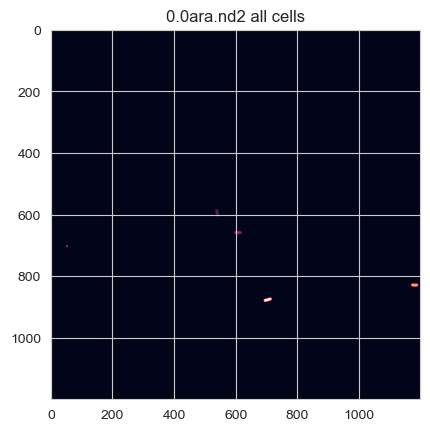

2024-09-24 19:39:45,351	[INFO]                                               	 line 258	Running on tiles. Now normalizing each tile separately.


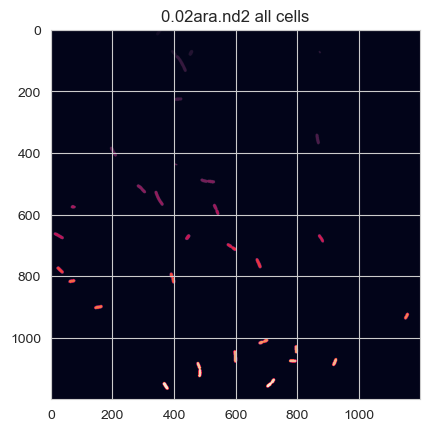

2024-09-24 19:39:48,289	[INFO]                                               	 line 258	Running on tiles. Now normalizing each tile separately.


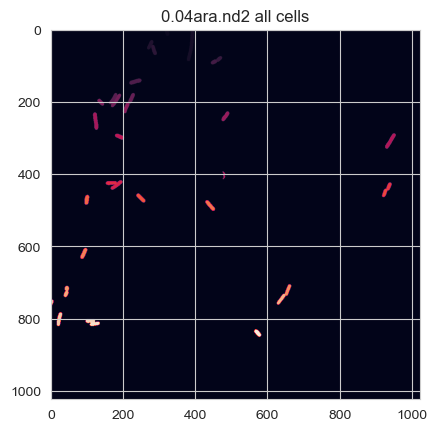

2024-09-24 19:39:50,916	[INFO]                                               	 line 258	Running on tiles. Now normalizing each tile separately.


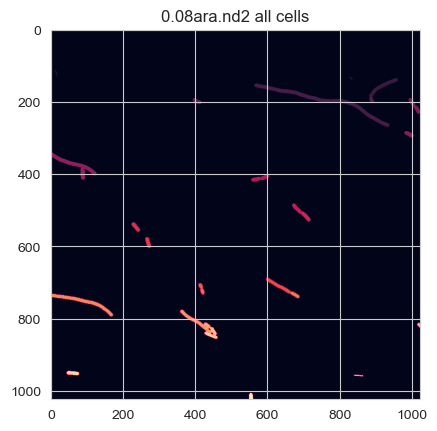

2024-09-24 19:39:53,546	[INFO]                                               	 line 258	Running on tiles. Now normalizing each tile separately.


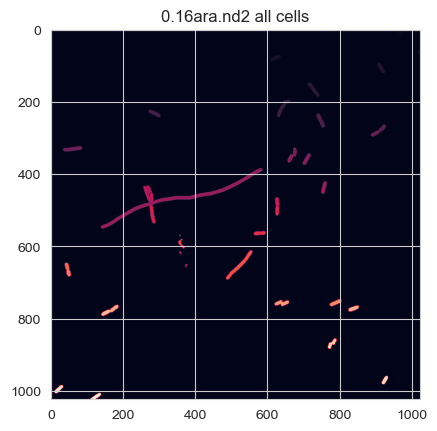

2024-09-24 19:39:55,638	[WARNING]  tifffile/tifffile.py          log_warning.()	 line 23104	<tifffile.TiffPage 0 @8> imagej_metadata failed with UnicodeDecodeError: 'utf-16-be' codec can't decode bytes in position 2180-2181: illegal encoding
2024-09-24 19:39:56,206	[INFO]     omnipose/utils.py             make...es_ND()	 line 258	Running on tiles. Now normalizing each tile separately.


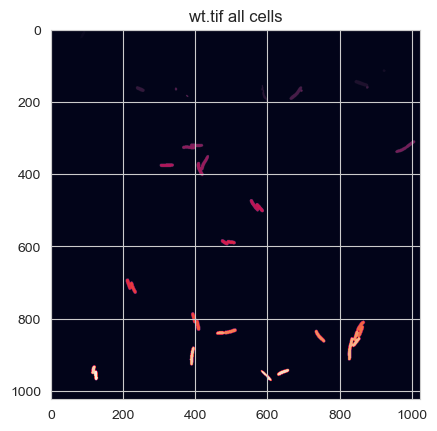

In [21]:
import tifffile as tiff
for filename in filenames:
    if (filename[-4:] == "tiff") or (filename[-3:] == "tif"):
        img = tiff.imread(filename)[frame, 0]
    else:
        img = import_frame(filename, frame = frame)
    mask = segment([img])[0].astype(np.int64)

    mask = label(mask).astype(np.uint32)
    plt.imshow(mask)
    plt.title(filename +" all cells")
    plt.show()
    cmkdir(filename[:-4])
    tiff.imwrite(filename[:-4] + "/all_dynamics_masks.tif", mask)
    


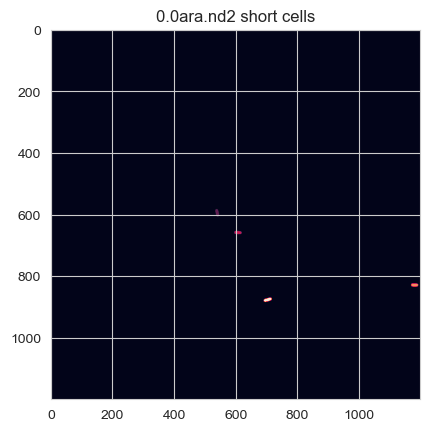

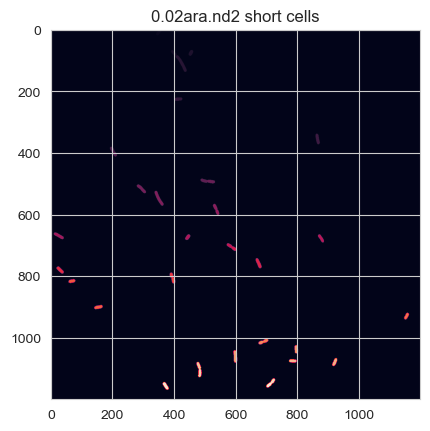

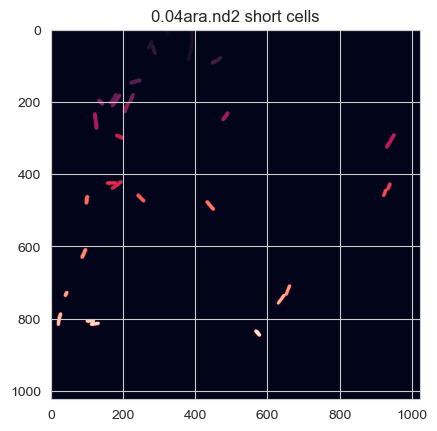

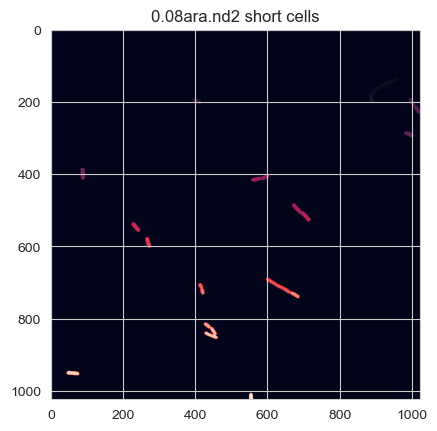

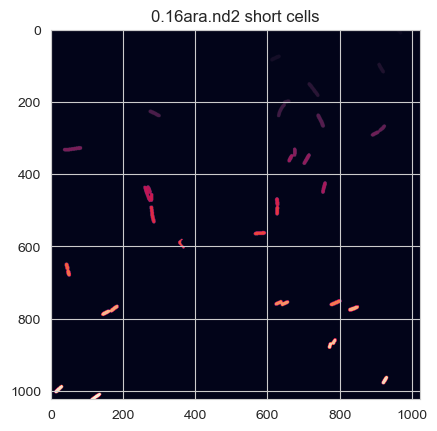

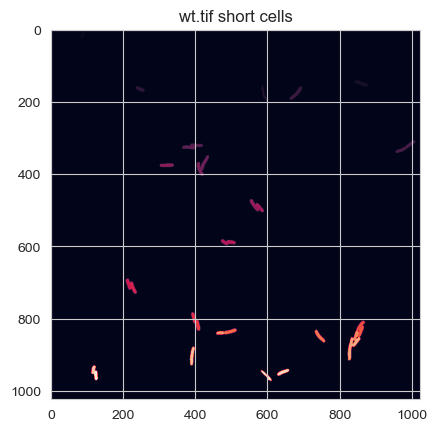

In [23]:
for filament, filename in zip(filamentous, filenames):
    mask = tiff.imread(filename[:-4] +"/all_dynamics_masks.tif")
    # now, get only filamentous cells!
    if filament:
        for idx in range(1, np.max(mask) + 1):
            if np.sum(mask == idx) < filamentous_area_cutoff: # arbitrary cutoff for filamentous cells.
                mask[mask == idx] = 0
        # and now make labels consecutive
        mask = label(mask).astype(np.uint8)
        if np.max(mask) == 0:
            print(f"skipping {filename} due to a lack of identified filamentous cells")
            continue
        plt.imshow(mask)
        plt.title(filename + " filamentous cells")
        plt.show()
        tiff.imwrite(filename[:-4] + "/dynamics_mask.tif", mask)
        continue
    for idx in range(1, np.max(mask) + 1):
        area = np.sum(mask == idx) 
        if (area > filamentous_area_cutoff) or (area < cell_noise_cutoff): # arbitrary cutoff for filamentous cells.
            mask[mask == idx] = 0
    # and now make labels consecutive
    mask = label(mask).astype(np.uint32)
    if np.max(mask) == 0:
        print(f"skipping {filename} due to a lack of identified short cells")
        continue
    plt.imshow(mask)
    plt.title(filename + " short cells")
    plt.show()
    tiff.imwrite(filename[:-4] + "/dynamics_mask.tif", mask)
